# Using Planet
## Basic usage

With petitRADTRANS, you can use the `Planet` object to easily access planetary parameters from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html). To use it, you first need to import it:

In [1]:
from petitRADTRANS.containers.planet import Planet

A `Planet` instance can be created by simply giving the name of the planet.

In [2]:
planet = Planet.get('HD 209458 b')  # internet required the first time

<div class="alert alert-warning">

Be careful to enter the **exact** name of your planet, inluding case and spaces.
</div>
    
You may see a bunch of warnings the first time you create a `Planet`. You can safely ignore them. This is simply an issue with the units used by the NASA Exoplanet Archive, which are not implemented in the module `astropy`. petitRADTRANS takes care of that issue.

All of the data has been downloaded from the NASA Exoplanet Archive! 

<div class="alert alert-warning">

- The attribute names used for `Planet` are sligthly different from the names used by the NASA Exoplanet Archive.
    
- The value of each attribute is taken from **the field with the smallest errorbars**, so different parameter may come from different sources. This is similar, but not identical, to the [NASA Exoplanet Archive Composite Planet Data Table](https://exoplanetarchive.ipac.caltech.edu/docs/pscp_about.html).
</div>

<div class="alert alert-block alert-info">

- All values are given in CGS units.
- The information are stored within your ["input_data"](https://petitradtrans.readthedocs.io/en/latest/content/installation.html#pre-installation-download-the-opacity-data) folder, in the planet_data directory.
-  The next time you need to use a `Planet` with the same name, no download will be necessary.
</div>

You can use `planet.__dict__` to check all the available attributes:

In [3]:
for key in planet.__dict__:
    print(f"{key}")

name
mass
mass_error_upper
mass_error_lower
radius
radius_error_upper
radius_error_lower
orbit_semi_major_axis
orbit_semi_major_axis_error_upper
orbit_semi_major_axis_error_lower
orbital_eccentricity
orbital_eccentricity_error_upper
orbital_eccentricity_error_lower
orbital_inclination
orbital_inclination_error_upper
orbital_inclination_error_lower
orbital_period
orbital_period_error_upper
orbital_period_error_lower
argument_of_periastron
argument_of_periastron_error_upper
argument_of_periastron_error_lower
epoch_of_periastron
epoch_of_periastron_error_upper
epoch_of_periastron_error_lower
ra
dec
x
y
z
reference_pressure
density
density_error_upper
density_error_lower
surface_gravity
surface_gravity_error_upper
surface_gravity_error_lower
equilibrium_temperature
equilibrium_temperature_error_upper
equilibrium_temperature_error_lower
insolation_flux
insolation_flux_error_upper
insolation_flux_error_lower
bond_albedo
bond_albedo_error_upper
bond_albedo_error_lower
transit_depth
transit_de

<div class="alert alert-block alert-info">

A description of these attributes is available on the [NASA Exoplanet Archive website](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html). Rememeber that for `Planet`, the attriubtes names are different and the units has been converted to CGS.
</div>

To get a value and its error bars, you can use, for example:

In [4]:
import numpy as np
from petitRADTRANS import nat_cst as nc

print(f"mass: {planet.mass / nc.m_jup:.2f} (+ {planet.mass_error_upper / nc.m_jup:.2f} - {np.abs(planet.mass_error_lower) / nc.m_jup:.2f}) M_Jup")

mass: 0.68 (+ 0.02 - 0.01) M_Jup


## Useful functions for observations from Earth
The `Planet` object provides functions to estimate useful parameters for observations from Earth:
- `Planet.get_airmass()`: to calculate the [airmass](https://en.wikipedia.org/wiki/Air_mass_(astronomy)),
- `Planet.get_barycentric_velocities()`: to calculate the the [barycentric velocity](https://docs.astropy.org/en/stable/coordinates/velocities.html#radial-velocity-corrections) relative to the planet.

These functions make use of the [`astropy.coordinates`](https://docs.astropy.org/en/stable/coordinates/index.html) module.

For example:

In [5]:
observing_time = 60068.37965278  # (MJD)

# Get airmass
airmass = Planet.get_airmass(
    ra=planet.ra,
    dec=planet.dec,
    time=observing_time,
    site_name='paranal observatory',
    time_format='mjd'
)

print(f"airmass: {airmass:.2f}")

# Get barycentric velocity
v_bary = Planet.get_barycentric_velocities(
    ra=planet.ra,
    dec=planet.dec,
    time=observing_time,
    site_name='paranal observatory',
    time_format='mjd'
) * 1e-3  # m.s-1 to km.s-1

print(f"v_bary: {v_bary:.2f} km.s-1")

airmass: 2.02
v_bary: 23.18 km.s-1


## Other useful functions
### Orbital phases
To get the orbital phases of an orbiting `Planet`, assuming low eccentricity, you can use `Planet.get_orbital_phases()`:

Text(0, 0.5, 'Orbital phase')

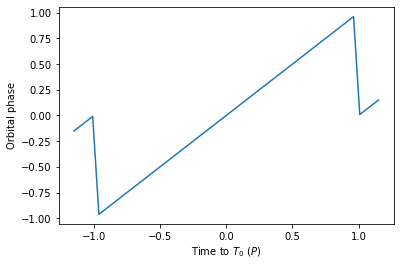

In [6]:
import matplotlib.pyplot as plt

times_to_mid_transit = np.linspace(-planet.orbital_period * 1.15, planet.orbital_period * 1.15)  # (s)

orbital_phases = Planet.get_orbital_phases(
    phase_start=0.0,  # start at mid-transit since the times are relative to mid-transit
    orbital_period=planet.orbital_period,
    times=times_to_mid_transit
)

plt.plot(times_to_mid_transit / planet.orbital_period, orbital_phases)
plt.xlabel(r'Time to $T_0$ ($P$)')
plt.ylabel('Orbital phase')

### Equilibrium temperature
If not provided by the NASA Exoplanet Archive, the equilibrium temperature of an orbiting `Planet`, you can use `Planet.calculate_planetary_equilibrium_temperature()`:

In [7]:
equilibrium_temperature, equilibrium_temperature_error_upper, equilibrium_temperature_error_lower = planet.calculate_planetary_equilibrium_temperature()

print(f"T_eq (calculated): {equilibrium_temperature:.2f} (+ {equilibrium_temperature_error_upper:.2f} - {np.abs(equilibrium_temperature_error_lower):.2f}) K")
print(f"T_eq (from archive): {planet.equilibrium_temperature:.2f} (+ {planet.equilibrium_temperature_error_upper:.2f} - {np.abs(planet.equilibrium_temperature_error_lower):.2f}) K")

T_eq (calculated): 1458.07 (+ 9.69 - 9.91) K
T_eq (from archive): 1459.00 (+ 12.00 - 12.00) K


<div class="alert alert-block alert-info">
    
The errorbars are calculated using the `petitRADTRANS.calculate_uncertainties()` function, using the uncertainties on the star effective temperature, the star radius, and the orbit semi-major axis.
</div>

### Mass, radius, surface gravity
If not provided by the NASA Exoplanet Archive, the mass, radius, and surface gravity (and associated errorbars) can be calculated using:
- `Planet.mass2surface_gravity`
- `Planet.surface_gravity2radius`
- `Planet.surface_gravity2mass`

For example:

In [8]:
mass, mass_error_upper, mass_error_lower = Planet.surface_gravity2mass(
    surface_gravity=planet.surface_gravity,
    radius=planet.radius,
    surface_gravity_error_upper=planet.surface_gravity_error_upper,
    surface_gravity_error_lower=planet.surface_gravity_error_lower,
    radius_error_upper=planet.radius_error_upper,
    radius_error_lower=planet.radius_error_lower
)

print(f"mass: {mass / nc.m_jup:.2f} (+ {mass_error_upper / nc.m_jup:.2f} - {np.abs(mass_error_lower) / nc.m_jup:.2f}) M_Jup")

mass: 0.68 (+ 0.03 - 0.03) M_Jup


## Loading and saving
By default, the `Planet` data are stored in a HDF5 file within your "input_data" folder, in the planet_data directory, and the data come from the NASA Exoplanet Archive.
However, if you want to customize the data of your `Planet` (or create one from scratch), you can use the `Planet.load()` and `Planet.save()` functions. For example:

In [9]:
import copy

my_planet = copy.deepcopy(planet)
my_planet.radius = 1.5 * nc.r_earth
my_planet.name='My Planet'

my_planet.save(filename='my_planet')  # this will save the Planet under my_planet.h5, in the working directory
my_planet.load(name='my_planet', filename='my_planet')

print(f"radius: {my_planet.radius / nc.r_earth:.2f} R_earth")

radius: 1.50 R_earth
